### Build targets

In [ ]:
def build_targets(pred_boxes, pred_cls, target, anchors, ignore_thres):

    ByteTensor = torch.cuda.ByteTensor if pred_boxes.is_cuda else torch.ByteTensor
    FloatTensor = torch.cuda.FloatTensor if pred_boxes.is_cuda else torch.FloatTensor

    nB = pred_boxes.size(0)
    nA = pred_boxes.size(1)
    nC = pred_cls.size(-1)
    nG = pred_boxes.size(2)

    # Output tensors
    obj_mask = ByteTensor(nB, nA, nG, nG).fill_(0)
    noobj_mask = ByteTensor(nB, nA, nG, nG).fill_(1)
    class_mask = FloatTensor(nB, nA, nG, nG).fill_(0)
    iou_scores = FloatTensor(nB, nA, nG, nG).fill_(0)
    tx = FloatTensor(nB, nA, nG, nG).fill_(0)
    ty = FloatTensor(nB, nA, nG, nG).fill_(0)
    tw = FloatTensor(nB, nA, nG, nG).fill_(0)
    th = FloatTensor(nB, nA, nG, nG).fill_(0)
    tcls = FloatTensor(nB, nA, nG, nG, nC).fill_(0)

    # Convert to position relative to box
    target_boxes = target[:, 2:6] * nG
    print(f'nG {nG}')
    gxy = target_boxes[:, :2]
    gwh = target_boxes[:, 2:]
    # Get anchors with best iou
    ious = torch.stack([bbox_wh_iou(anchor, gwh) for anchor in anchors])
    print('anchors', anchors)
    print('ious', ious)
    best_ious, best_n = ious.max(0)
    print('best_n', best_n)
    # Separate target values
    b, target_labels = target[:, :2].long().t()
    print('b', b)
    gx, gy = gxy.t()
    gw, gh = gwh.t()
    print(f'gx, gy, gw, gh {gx} {gy} {gw} {gh}')
    gi, gj = gxy.long().t()
    print(f'gi gj {gi} {gj}')
    # Set masks
    obj_mask[b, best_n, gj, gi] = 1
    noobj_mask[b, best_n, gj, gi] = 0

    # Set noobj mask to zero where iou exceeds ignore threshold
    for i, anchor_ious in enumerate(ious.t()):
        print('anchor_ious > ignore_thres', anchor_ious > ignore_thres)
        noobj_mask[b[i], anchor_ious > ignore_thres, gj[i], gi[i]] = 0

    # Coordinates
    tx[b, best_n, gj, gi] = gx - gx.floor()
    ty[b, best_n, gj, gi] = gy - gy.floor()
    # Width and height
    tw[b, best_n, gj, gi] = torch.log(gw / anchors[best_n][:, 0] + 1e-16)
    th[b, best_n, gj, gi] = torch.log(gh / anchors[best_n][:, 1] + 1e-16)
    # One-hot encoding of label
    tcls[b, best_n, gj, gi, target_labels] = 1
    # Compute label correctness and iou at best anchor
    class_mask[b, best_n, gj, gi] = (pred_cls[b, best_n, gj, gi].argmax(-1) == target_labels).float()
    iou_scores[b, best_n, gj, gi] = bbox_iou(pred_boxes[b, best_n, gj, gi], target_boxes, x1y1x2y2=False)

    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls


In [1]:
import torch

from utils import iou_vectorized

def make_targets(x, target, anchors, ignore_thres):
    '''
    
    Arguments
    ---------
    x: torch.FloatTensor
        Predictions \in (B, P, 5+classes) where P = A * (w * h)
    '''
    # reshape tensors so that it is easier to use them in building targets
    x = x.view(B, w, h, num_anchs, num_feats)
    x = x.permute(0, 3, 1, 2, 4).contiguous() # -> (B, A, w, h, 5+classes)
    
    B, num_anchs, w, h, num_feats = x.size()
    
    # create the placeholders
    noobj_mask = torch.ones(obj_mask).byte()
    obj_mask = torch.zeros_like(B, num_anchs, w, h).byte()
    class_mask = torch.zeros_like(obj_mask).float()
    iou_scores = torch.zeros_like(obj_mask).float()
    tx = torch.zeros_like(obj_mask).float()
    ty = torch.zeros_like(obj_mask).float()
    tw = torch.zeros_like(obj_mask).float()
    th = torch.zeros_like(obj_mask).float()
    tcls = torch.zeros(B, num_anchs, w, h, num_feats).float()
    
    # since the target bbox coordinates are in (0, 1) but we predict on one
    # of the 3 scales (YOLOv3) we multiply it by the number of grid cells
    # todo: more motivation?
    gt_bboxes = target[:, 2:6] * w # or * h
    gxy = gt_bboxes[:, :2]
    gwh = gt_bboxes[:, 2:]
    # ious between scaled anchors (anchors_from_cfg / stride) and gt bboxes
    ious = iou_vectorized(anchors, gwh, without_center_coords=True)
    # 
    best_ious, best_n = ious.max(0)
    
    # iou_vectorized(anchors, target[:, 4:] * , without_center_coords=True)
    
    return iou_scores, class_mask, obj_mask, noobj_mask, tx, ty, tw, th, tcls


anchors = torch.tensor([[ 3.6250,  2.8125],
        [ 4.8750,  6.1875],
        [11.6562, 10.1875]]).float()

ignore_thresh = 0.5
B = 2
H, W = 13, 13
classes = 80
C = len(anchors) * (H * W)

target = torch.tensor([
    [ 0.0000, 37.0000,  0.3425,  0.7006,  0.2527,  0.0898],
    [ 0.0000,  0.0000,  0.4857,  0.4737,  0.6151,  0.4413],
    [ 1.0000, 62.0000,  0.6833,  0.2446,  0.4339,  0.1869],
    [ 1.0000, 14.0000,  0.7664,  0.5047,  0.1376,  0.1346],
    [ 1.0000, 57.0000,  0.1318,  0.3852,  0.2636,  0.4733],
    [ 1.0000,  0.0000,  0.4073,  0.5028,  0.4478,  0.6808],
    [ 1.0000,  0.0000,  0.4967,  0.5625,  0.2727,  0.3840],
    [ 2.0000, 10.0000,  0.2710,  0.6109,  0.4810,  0.5519],
    [ 2.0000,  0.0000,  0.6921,  0.4621,  0.5748,  0.6939]
]).float()

x = torch.rand(B, C, 4 + 1 + classes).float()

pred_boxes = x[:, :, :4]
pred_cls = x[:, :, 4]

In [2]:
# tensor([[0.3762, 0.2222, 0.5835, 0.3070, 0.4453, 0.1979, 0.5563, 0.2272, 0.1512],
#         [0.1272, 0.5818, 0.3698, 0.1038, 0.6989, 0.5855, 0.5866, 0.6723, 0.4475],
#         [0.0323, 0.3863, 0.1154, 0.0264, 0.1775, 0.4339, 0.1490, 0.3778, 0.5677]])

In [3]:
#     ious = torch.stack([bbox_wh_iou(anchor, gwh) for anchor in anchors])

In [4]:
def bbox_wh_iou(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area

In [9]:

torch.stack([bbox_wh_iou(anchor, target[:, 4:] * 13) for anchor in anchors])

tensor([[0.3762, 0.2222, 0.5836, 0.3070, 0.4453, 0.1979, 0.5563, 0.2273, 0.1513],
        [0.1271, 0.5818, 0.3699, 0.1038, 0.6990, 0.5855, 0.5867, 0.6724, 0.4475],
        [0.0323, 0.3863, 0.1154, 0.0264, 0.1776, 0.4339, 0.1490, 0.3778, 0.5676]])

In [11]:
iou_vectorized(anchors, target[:, 4:] * 13, without_center_coords=True).max(0)

(tensor([0.3762, 0.5818, 0.5836, 0.3070, 0.6990, 0.5855, 0.5867, 0.6724, 0.5676]),
 tensor([0, 1, 0, 0, 1, 1, 1, 1, 2]))

In [7]:
anchors.shape

torch.Size([3, 2])

In [8]:
a = torch.cat([torch.ones_like(anchors), anchors], dim=1)
b = torch.cat([torch.ones_like(target[:, 4:]), target[:, 4:] * 13], dim=1)
iou_vectorized(a, b)

tensor([[0.3762, 0.2222, 0.5836, 0.3070, 0.4453, 0.1979, 0.5563, 0.2273, 0.1513],
        [0.1271, 0.5818, 0.3699, 0.1038, 0.6990, 0.5855, 0.5867, 0.6724, 0.4475],
        [0.0323, 0.3863, 0.1154, 0.0264, 0.1776, 0.4339, 0.1490, 0.3778, 0.5676]])

In [ ]:
# todo: decide on iou (change the function to accept no center entries)

### Prediction permutations <->

In [1]:
import torch
B, C, w, h = 1, 255, 19, 19

x = torch.arange(0, C*w*h).view((B, C, w, h))

B, C, w, h = x.size()
# read layer's info
classes = 80
num_anchs = 3
# bbox coords + obj score + class scores
num_feats = 4 + 1 + classes

## Forward
# transform the predictions
# (B, ((4+1+classes)*num_achors), Gi, Gi)
# -> (B, Gi*Gi*num_anchors, (4+1+classes), Gi, Gi)
x = x.view(B, num_anchs, num_feats, w, h)
x = x.permute(0, 3, 4, 1, 2).contiguous() # (B, w, h, num_anchs, num_feats)
x = x.view(B, h*w*num_anchs, num_feats)

## Backward
x = x.view(B, w, h, num_anchs, num_feats)
x = x.permute(0, 3, 4, 1, 2).contiguous()
x = x.view(B, num_feats*num_anchs, w, h)

prediction = (
    x.view(num_samples, self.num_anchors, self.num_classes + 5, grid_size, grid_size)
    .permute(0, 1, 3, 4, 2) # (B, A, G, G, C)
    .contiguous()
)

(x - torch.arange(0, C*w*h).view((B, C, w, h))).sum()

tensor(0)

In [1]:
import torch
B, C, w, h = 1, 255, 19, 19

x = torch.arange(0, C*w*h).view((B, C, w, h))

B, C, w, h = x.size()
# read layer's info
classes = 80
num_anchs = 3
# bbox coords + obj score + class scores
num_feats = 4 + 1 + classes

x = x.view(B, w, h, num_anchs, num_feats)
x = x.permute(0, 3, 4, 1, 2).contiguous() # -> (B, A, 5+classes, w, h)
x = x.view(B, num_feats*num_anchs, w, h) # ->  (B, A*(5+classes), w, h)
x = x.view(B, num_anchs, num_feats, w, h)
x = x.permute(0, 1, 3, 4, 2).contiguous()

a = x

In [2]:
import torch
B, C, w, h = 1, 255, 19, 19

x = torch.arange(0, C*w*h).view((B, C, w, h))

B, C, w, h = x.size()
# read layer's info
classes = 80
num_anchs = 3
# bbox coords + obj score + class scores
num_feats = 4 + 1 + classes

x = x.view(B, w, h, num_anchs, num_feats)
x = x.permute(0, 3, 1, 2, 4).contiguous()

b = x

In [3]:
(a != b).sum()

tensor(0)

### get predictions + show

In [2]:
from matplotlib import pyplot as plt
import cv2
import torch

from darknet import Darknet
from utils import predict_and_save, scale_numbers, letterbox_pad

model = Darknet('cfg/yolov3_608x608.cfg')
weight_file = 'weights/yolov3.weights'
model.load_weights(weight_file)
model.eval();

device = torch.device('cpu')
labels_path='./data/coco.names'
# img_path = 'dog-cycle-car.png'
# img_path = 'databreakfast_spb.jpg'
img_path = 'typical_russian_morning.jpg'
save_path = './output.jpg'
show = True

img_raw = cv2.imread(img_path)
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

# add letterbox padding and save the pad sizes and scalling coefficient
# to use it latter when drawing bboxes on the original image
H, W, C = img_raw.shape
H_new, W_new, scale = scale_numbers(H, W, model.in_width)
img = cv2.resize(img_raw, (W_new, H_new))
img, pad_sizes = letterbox_pad(img)

# HWC -> CHW, scale intensities to [0, 1], send to pytorch, add 'batch-'dimension
img = img.transpose((2, 0, 1))
img = img / 255
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)

prediction = model(img, device)
# (76 x 76 + 38 x 38 + 19 x 19) * 3 = 22743
print(prediction.shape)

we also can remove bias due to bn
make_layers returns net_info as well. check whether it"s necessary
shortcut is using output[i-1] instead of x check whether works with x
NOTE THAT CONV BEFORE YOLO USES (num_classes filters) * num_anch
changing predictions in the nms loop make sure that it is not used later
not adding +1 in nms
tensor([[ 3.6250,  2.8125],
        [ 4.8750,  6.1875],
        [11.6562, 10.1875]])


/home/vladimir/miniconda3/envs/proj/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/vladimir/miniconda3/envs/proj/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor([[1.8750, 3.8125],
        [3.8750, 2.8125],
        [3.6875, 7.4375]])
tensor([[1.2500, 1.6250],
        [2.0000, 3.7500],
        [4.1250, 2.8750]])
torch.Size([1, 22743, 85])


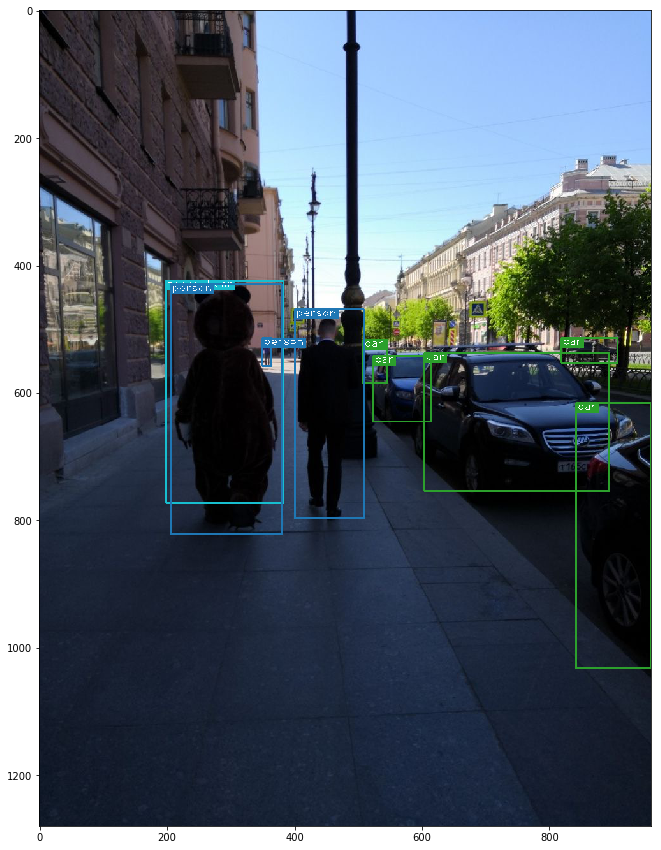

In [4]:
prediction = predict_and_save(img_path, save_path, model, device, labels_path, show)

### Dataset + show examples with bboxes

In [1]:
import cv2 
from matplotlib import pyplot as plt
from dataset import WIDERdataset

./data/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg
torch.Size([1, 2]) torch.Size([1, 10])


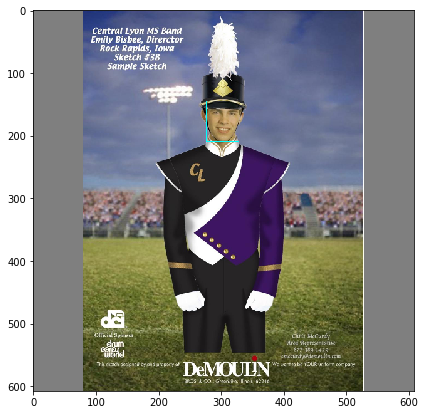

In [2]:
# train
train_dataset = WIDERdataset('./data/train.json', 'train', 608)

img, targets = train_dataset.__getitem__(0)

for target in targets:
    H, W, C = img.shape
    top_left_x = int(target[2] * W) - int((target[4] * W) // 2)
    top_left_y = int(target[3] * H) - int((target[5] * H) // 2)
    bottom_right_x = int(target[2] * W) + int((target[4] * W) // 2)
    bottom_right_y = int(target[3] * H) + int((target[5] * H) // 2)

    top_left_coords = top_left_x, top_left_y
    # top_left_coords = 100, 200
    bottom_right_coords = bottom_right_x, bottom_right_y
    # bottom_right_coords = 300, 400
    # print(top_left_coords, bottom_right_coords)
    cv2.rectangle(img, top_left_coords, bottom_right_coords, (0, 255, 255), 1)

plt.figure(figsize=(7, 7))
plt.imshow(img)